In [1]:
pip install requests beautifulsoup4 pillow selenium rembg shap scikit-learn webdriver-manager pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Load the dataset
file_path = 'mergeFinalC_with_local.csv'
data = pd.read_csv(file_path)

# Define PPS calculation function
def calculate_pps(row):
    if row['shot_made_flag'] == 1:
        if row['shot_distance'] > 23.75:  # Assuming 3-point shots are beyond 23.75 feet
            return 3
        else:
            return 2
    else:
        return 0

# Apply PPS calculation
data['pps'] = data.apply(calculate_pps, axis=1)

# Define zones based on shot_distance and x, y coordinates
def categorize_zone_xy(row):
    if row['shot_distance'] <= 5:
        return 'Restricted Area'
    elif row['shot_distance'] <= 15:
        if row['x'] > 0:
            return 'Right Paint (Non-RA)'
        else:
            return 'Left Paint (Non-RA)'
    elif row['shot_distance'] <= 22:
        if row['x'] > 0:
            return 'Right Mid-Range'
        else:
            return 'Left Mid-Range'
    elif row['shot_distance'] > 22:
        if abs(row['x']) > 22:
            if row['x'] > 0:
                return 'Right Corner 3'
            else:
                return 'Left Corner 3'
        else:
            if row['x'] > 0:
                return 'Right Above the Break 3'
            else:
                return 'Left Above the Break 3'
    else:
        return 'Other'

data['shot_zone_xy'] = data.apply(categorize_zone_xy, axis=1)

# Group by player and custom shot zone with x, y coordinates
grouped_xy = data.groupby(['name', 'shot_zone_xy'])

# Calculate player PPS for each zone
player_pps_xy = grouped_xy['pps'].mean().reset_index()

# Calculate league average PPS for each zone
league_grouped_xy = data.groupby(['shot_zone_xy'])
league_pps_xy = league_grouped_xy['pps'].mean().reset_index()
league_pps_xy.rename(columns={'pps': 'league_pps'}, inplace=True)

# Merge player PPS with league PPS
merged_pps_xy = pd.merge(player_pps_xy, league_pps_xy, on='shot_zone_xy')

# Calculate shot frequency for each player in each zone
player_shot_counts_xy = grouped_xy['pps'].count().reset_index()
player_shot_counts_xy.rename(columns={'pps': 'shot_count'}, inplace=True)

# Calculate total shots for each player
total_shots_xy = data.groupby('name')['pps'].count().reset_index()
total_shots_xy.rename(columns={'pps': 'total_shots'}, inplace=True)

# Merge shot counts with total shots
player_shot_counts_xy = pd.merge(player_shot_counts_xy, total_shots_xy, on='name')
player_shot_counts_xy['shot_frequency'] = player_shot_counts_xy['shot_count'] / player_shot_counts_xy['total_shots']

# Merge shot frequency data with PPS data
merged_pps_xy = pd.merge(merged_pps_xy, player_shot_counts_xy[['name', 'shot_zone_xy', 'shot_frequency']], on=['name', 'shot_zone_xy'])

# Generate recommendations
def generate_recommendation_xy(row):
    if row['pps'] > row['league_pps']:
        if row['shot_frequency'] < 0.2:  # Arbitrary threshold to avoid recommending high-frequency zones
            return 'Shoot More'
        else:
            return 'Maintain Frequency'
    else:
        return 'Shoot Less'

merged_pps_xy['recommendation'] = merged_pps_xy.apply(generate_recommendation_xy, axis=1)

# Filter to keep only the strongest recommendations (minimum 2, maximum 4 per player)
def get_top_recommendations(df):
    df = df.sort_values(by=['pps'], ascending=False)
    top_recommendations = df.head(4) if len(df) > 4 else df
    return top_recommendations

top_recommendations = merged_pps_xy.groupby('name').apply(get_top_recommendations).reset_index(drop=True)

# Format the recommendations into a single string per player
def format_recommendations(df):
    recommendations = df['shot_zone_xy'] + ": " + df['recommendation']
    return "; ".join(recommendations)

final_recommendations = top_recommendations.groupby('name').apply(format_recommendations).reset_index()
final_recommendations.columns = ['player', 'recommendations']

# Save the final recommendations to a CSV file
final_recommendations.to_csv('Player_Recommendations.csv', index=False)

# Display the final recommendations
final_recommendations.head()

C:\Users\juani\AppData\Local\Temp\ipykernel_30336\1728903199.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_recommendations = merged_pps_xy.groupby('name').apply(get_top_recommendations).reset_index(drop=True)
C:\Users\juani\AppData\Local\Temp\ipykernel_30336\1728903199.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_recommendations = top_recommendations.groupby('name').apply(format_re

,player,recommendations
0,Carlos Boozer,Restricted Area: Maintain Frequency; Left Pain...
1,Dwight Buycks,Left Corner 3: Shoot More; Left Paint (Non-RA)...
2,Ed Davis,Restricted Area: Maintain Frequency; Right Pai...
3,Jabari Brown,Right Corner 3: Shoot More; Left Above the Bre...
4,Jeremy Lin,Right Corner 3: Shoot More; Restricted Area: S...


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Circle, Rectangle, Arc

def draw_lakers_court(ax=None, lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    violet = '#552583'
    yellow = '#FDB927'

    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=violet, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=violet)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=violet, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=violet, fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=violet)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=violet, linestyle='dashed')
    restricted = Circle((0, 0), radius=30, linewidth=lw, color=violet, linestyle='dashed', fill=False)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=violet)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=violet)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=violet)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=yellow)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=yellow)
    
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw,
                      restricted, corner_three_a, corner_three_b, three_arc, center_outer_arc, center_inner_arc]
    for element in court_elements:
        ax.add_patch(element)

    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=violet, fill=False)
        ax.add_patch(outer_lines)

    ax.set_xlim(-250, 250)
    ax.set_ylim(-47.5, 422.5)
    ax.set_aspect('equal')
    return ax

# Load data
data_path = 'mergeFinalC_with_local.csv'
shots_data = pd.read_csv(data_path)

# Get unique player names
players = shots_data['name'].unique()

# Create a shot chart for each player
for player in players:
    player_shots = shots_data[shots_data['name'] == player]
    
    fig, ax = plt.subplots(figsize=(15, 13))
    draw_lakers_court(ax, outer_lines=True)
    
    sns.scatterplot(data=player_shots, x='x', y='y', hue='shot_made_flag', palette=['red', 'green'], style='shot_made_flag',
                    markers=['o', 'o'], s=50, alpha=0.6)
    
    plt.xlim(-250, 250)
    plt.ylim(-47.5, 422.5)
    plt.gca().invert_yaxis()
    plt.title(f'{player} Lakers Shot Chart', fontsize=16)
    plt.legend(title='Shot Result', loc='upper right', fontsize=12, title_fontsize=12)
    
    # Save the figure
    plt.savefig(f'{player}_shot_chart.png')
    plt.close(fig)

In [21]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from rembg import remove
import time

# Function to download and save player images
def download_player_image(player_name, save_path):
    search_query = f"Los angeles Lakers {player_name} .png"
    search_url = f"https://www.google.com/search?tbm=isch&q={search_query}"
    
    # Initialize Selenium WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
    driver.get(search_url)
    
    # Wait for images to load
    time.sleep(2)
    
    # Get image results
    image_elements = driver.find_elements(By.CSS_SELECTOR, 'img')
    image_url = None
    for image_element in image_elements:
        src = image_element.get_attribute('src')
        alt = image_element.get_attribute('alt')
        if src and src.startswith('http') and 'lakers' in alt.lower():
            image_url = src
            break
    
    driver.quit()
    
    if image_url:
        image_response = requests.get(image_url)
        image = Image.open(BytesIO(image_response.content))

        # Remove the background
        image = remove(image)

        # Convert to PNG and save the image
        image = image.convert("RGBA")
        image_save_path = os.path.join(save_path, f"{player_name}.png")
        image.save(image_save_path, format="PNG")
        print(f"Saved image for {player_name}")
    else:
        print(f"No suitable image found for {player_name}")

# Function to create directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Main function to scrape images for all players in the dataset
def main():
    # Load player names from the dataset
    data_path = 'mergeFinalC_with_local.csv'
    shots_data = pd.read_csv(data_path)
    players = shots_data['name'].unique()

    # Create a directory to save player images
    save_path = 'player_images'
    create_directory(save_path)

    # Download and save images for each player
    for player in players:
        download_player_image(player, save_path)

if __name__ == "__main__":
    main()


No suitable image found for Carlos Boozer
Saved image for Jordan Hill
Saved image for Wesley Johnson
Saved image for Kobe Bryant
Saved image for Jeremy Lin
Saved image for Jordan Clarkson
Saved image for Ronnie Price
Saved image for Julius Randle
Saved image for Xavier Henry
Saved image for Ed Davis
Saved image for Robert Sacre
Saved image for Wayne Ellington
Saved image for Ryan Kelly
Saved image for Nick Young
Saved image for Tarik Black
Saved image for Jabari Brown
No suitable image found for Dwight Buycks
Saved image for Vander Blue


## Modelos Predictivos

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the model_outputs directory exists
output_dir = "model_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load the dataset
data_path = 'mergeFinalC_with_local.csv'
data = pd.read_csv(data_path)

# Select relevant features for modeling
features = ['period', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'x', 'y', 'defender_distance', 'shot_clock']
target = 'shot_made_flag'

# Drop rows with missing values in relevant columns
data = data.dropna(subset=features + [target])

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVC': SVC(random_state=42)
}

# Train and evaluate models
model_accuracies = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Save model accuracies to a CSV file
model_accuracies_df = pd.DataFrame(model_accuracies.items(), columns=['Model', 'Accuracy'])
model_accuracies_df.to_csv(os.path.join(output_dir, 'model_accuracies.csv'), index=False)

# Select the best model (highest accuracy)
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = models[best_model_name]

# Compute feature importance
importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else [0] * len(features)
feature_importance = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance with Lakers colors
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette=['#552583', '#FDB927'])
plt.title('Feature Importance')
plt.savefig(os.path.join(output_dir, 'feature_importance.png'))
plt.close()

# Separate data into 2-pointers and 3-pointers
data_2pointers = data[data['shot_distance'] <= 23.75]
data_3pointers = data[data['shot_distance'] > 23.75]

# Function to train model and get feature importance
def analyze_feature_importance(data_subset):
    X = data_subset[features]
    y = data_subset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model.fit(X_train_scaled, y_train)
    importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else [0] * len(features)
    feature_importance = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
    return feature_importance

# Analyze feature importance for 2-pointers
feature_importance_2pointers = analyze_feature_importance(data_2pointers)
print("Feature Importance for 2-pointers:")
print(feature_importance_2pointers)

# Save feature importance for 2-pointers to a CSV file
feature_importance_2pointers.to_csv(os.path.join(output_dir, 'feature_importance_2pointers.csv'), index=False)

# Analyze feature importance for 3-pointers
feature_importance_3pointers = analyze_feature_importance(data_3pointers)
print("Feature Importance for 3-pointers:")
print(feature_importance_3pointers)

# Save feature importance for 3-pointers to a CSV file
feature_importance_3pointers.to_csv(os.path.join(output_dir, 'feature_importance_3pointers.csv'), index=False)

# Plot feature importance for 2-pointers with Lakers colors
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_2pointers, palette=['#552583', '#FDB927'])
plt.title('Feature Importance for 2-pointers')
plt.savefig(os.path.join(output_dir, 'feature_importance_2pointers.png'))
plt.close()

# Plot feature importance for 3-pointers with Lakers colors
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_3pointers, palette=['#552583', '#FDB927'])
plt.title('Feature Importance for 3-pointers')
plt.savefig(os.path.join(output_dir, 'feature_importance_3pointers.png'))
plt.close()


## Modelos predictivos + SHAP

In [68]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the model_outputs directory exists
output_dir = "model_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load the dataset
data_path = 'mergeFinalC_with_local.csv'
data = pd.read_csv(data_path)

# Select relevant features for modeling
features = ['period', 'minutes_remaining','touch_time','local','dribbles', 'seconds_remaining', 'shot_distance', 'x', 'y', 'defender_distance', 'shot_clock']
target = 'shot_made_flag'

# Drop rows with missing values in relevant columns
data = data.dropna(subset=features + [target])

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVC': SVC(random_state=42)
}

# Train and evaluate models
model_accuracies = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Save model accuracies to a CSV file
model_accuracies_df = pd.DataFrame(model_accuracies.items(), columns=['Model', 'Accuracy'])
model_accuracies_df.to_csv(os.path.join(output_dir, 'model_accuracies.csv'), index=False)

# Select the best model (highest accuracy)
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = models[best_model_name]

# Compute feature importance
importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else [0] * len(features)
feature_importance = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance with Lakers colors
plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette=['#552583', '#FDB927'])
plt.title('Feature Importance')
plt.savefig(os.path.join(output_dir, 'feature_importance.png'))
plt.close()

# Separate data into 2-pointers and 3-pointers
data_2pointers = data[data['shot_distance'] <= 23.75]
data_3pointers = data[data['shot_distance'] > 23.75]

# Function to train model and get feature importance
def analyze_feature_importance(data_subset):
    X = data_subset[features]
    y = data_subset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model.fit(X_train_scaled, y_train)
    importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else [0] * len(features)
    feature_importance = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
    return feature_importance

# Analyze feature importance for 2-pointers
feature_importance_2pointers = analyze_feature_importance(data_2pointers)
print("Feature Importance for 2-pointers:")
print(feature_importance_2pointers)

# Save feature importance for 2-pointers to a CSV file
feature_importance_2pointers.to_csv(os.path.join(output_dir, 'feature_importance_2pointers.csv'), index=False)

# Analyze feature importance for 3-pointers
feature_importance_3pointers = analyze_feature_importance(data_3pointers)
print("Feature Importance for 3-pointers:")
print(feature_importance_3pointers)

# Save feature importance for 3-pointers to a CSV file
feature_importance_3pointers.to_csv(os.path.join(output_dir, 'feature_importance_3pointers.csv'), index=False)

# Plot feature importance for 2-pointers with Lakers colors
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_2pointers, palette=['#552583', '#FDB927'])
plt.title('Feature Importance for 2-pointers')
plt.savefig(os.path.join(output_dir, 'feature_importance_2pointers.png'))
plt.close()

# Plot feature importance for 3-pointers with Lakers colors
plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=feature_importance_3pointers, palette=['#552583', '#FDB927'])
plt.title('Feature Importance for 3-pointers')
plt.savefig(os.path.join(output_dir, 'feature_importance_3pointers.png'))
plt.close()

RandomForest Accuracy: 0.6349
LogisticRegression Accuracy: 0.6121
GradientBoosting Accuracy: 0.6410


c:\Users\juani\OneDrive\Documentos\ITBA\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.6368
SVC Accuracy: 0.6368
Feature Importance:
              feature  importance
6       shot_distance    0.451803
8                   y    0.128142
9   defender_distance    0.099276
2          touch_time    0.089204
7                   x    0.061619
10         shot_clock    0.060422
1   minutes_remaining    0.035385
5   seconds_remaining    0.028032
4            dribbles    0.025632
0              period    0.017209
3               local    0.003275


C:\Users\juani\AppData\Local\Temp\ipykernel_30336\1113631062.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette=['#552583', '#FDB927'])
C:\Users\juani\AppData\Local\Temp\ipykernel_30336\1113631062.py:72: UserWarning: 
The palette list has fewer values (2) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='importance', y='feature', data=feature_importance, palette=['#552583', '#FDB927'])


Feature Importance for 2-pointers:
              feature  importance
6       shot_distance    0.459704
9   defender_distance    0.112460
2          touch_time    0.102147
8                   y    0.096614
10         shot_clock    0.061988
7                   x    0.056236
5   seconds_remaining    0.050287
1   minutes_remaining    0.020972
4            dribbles    0.017291
0              period    0.015105
3               local    0.007196
Feature Importance for 3-pointers:
              feature  importance
7                   x    0.173780
9   defender_distance    0.168066
10         shot_clock    0.138357
8                   y    0.129172
5   seconds_remaining    0.103849
1   minutes_remaining    0.091356
2          touch_time    0.068032
6       shot_distance    0.052360
4            dribbles    0.046295
0              period    0.022843
3               local    0.005891


C:\Users\juani\AppData\Local\Temp\ipykernel_30336\1113631062.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_2pointers, palette=['#552583', '#FDB927'])
C:\Users\juani\AppData\Local\Temp\ipykernel_30336\1113631062.py:112: UserWarning: 
The palette list has fewer values (2) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='importance', y='feature', data=feature_importance_2pointers, palette=['#552583', '#FDB927'])
C:\Users\juani\AppData\Local\Temp\ipykernel_30336\1113631062.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_3pointers, p

In [51]:
data.columns

Index(['name', 'team_name', 'game_date', 'season', 'espn_player_id', 'team_id',
       'espn_game_id', 'period', 'minutes_remaining', 'seconds_remaining',
       'shot_made_flag', 'action_type', 'shot_type', 'shot_distance',
       'opponent', 'x', 'y', 'dribbles', 'touch_time', 'defender_name',
       'defender_distance', 'shot_clock', 'pctimestring', 'total_time',
       'datetime', 'score', 'matchup_home', 'local', 'player',
       'recommendations'],
      dtype='object')

## Predictive Model + Shap

RandomForest Accuracy: 0.6349
LogisticRegression Accuracy: 0.6121
GradientBoosting Accuracy: 0.6410


c:\Users\juani\OneDrive\Documentos\ITBA\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.6368
SVC Accuracy: 0.6368


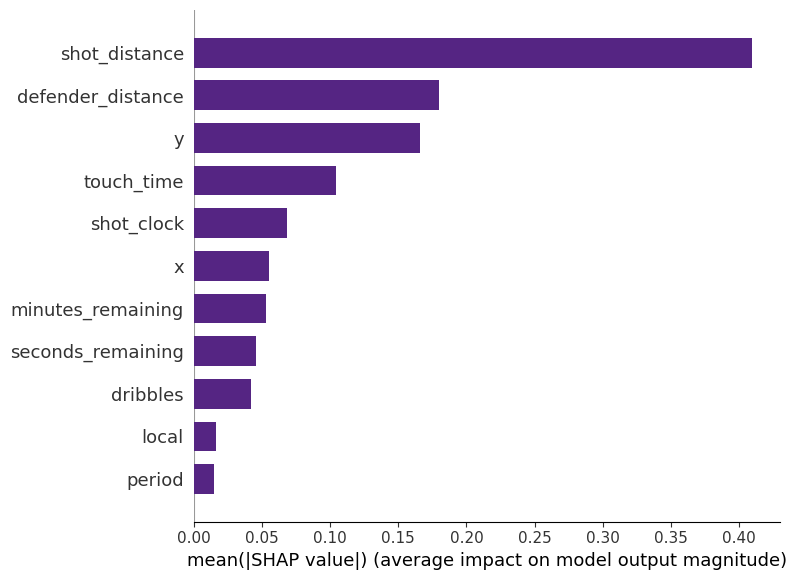

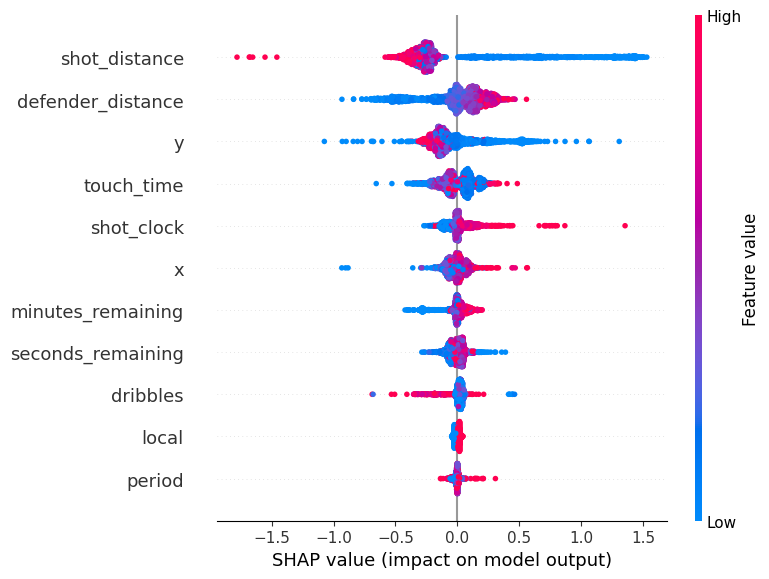

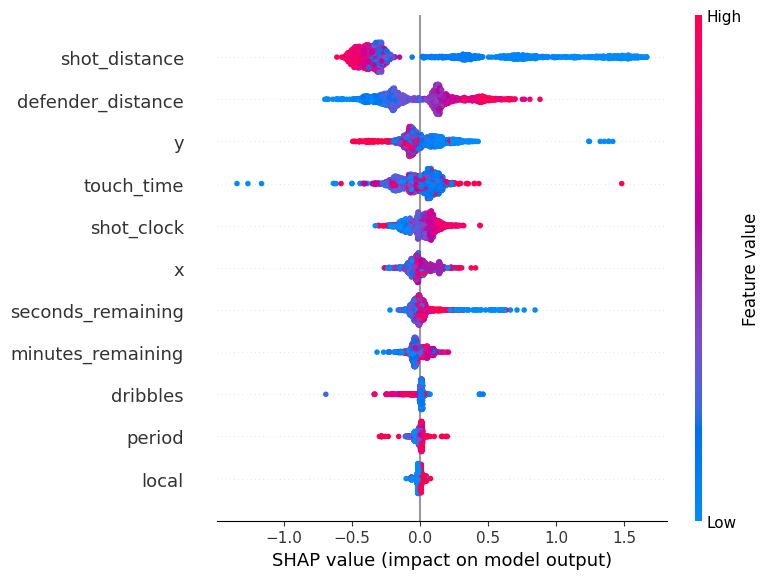

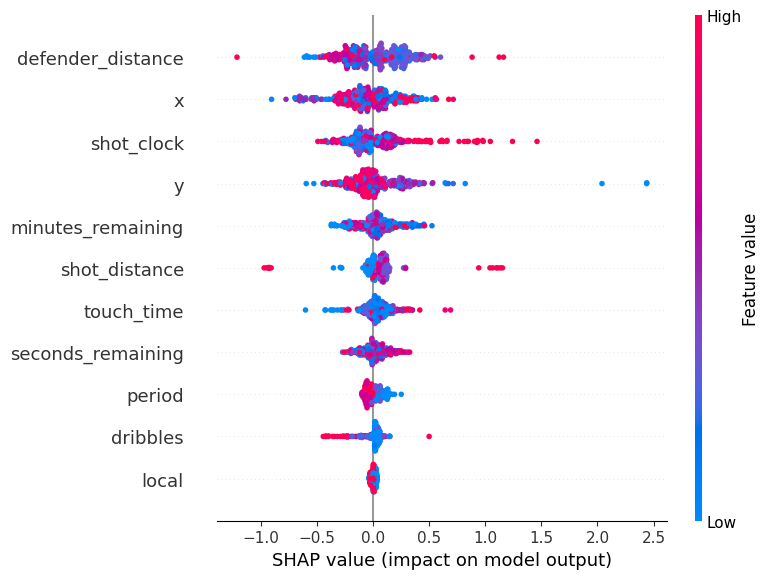

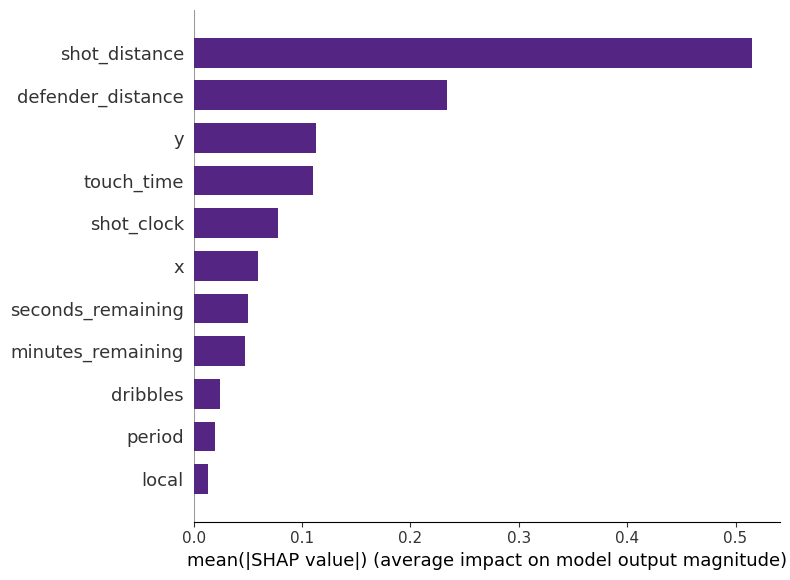

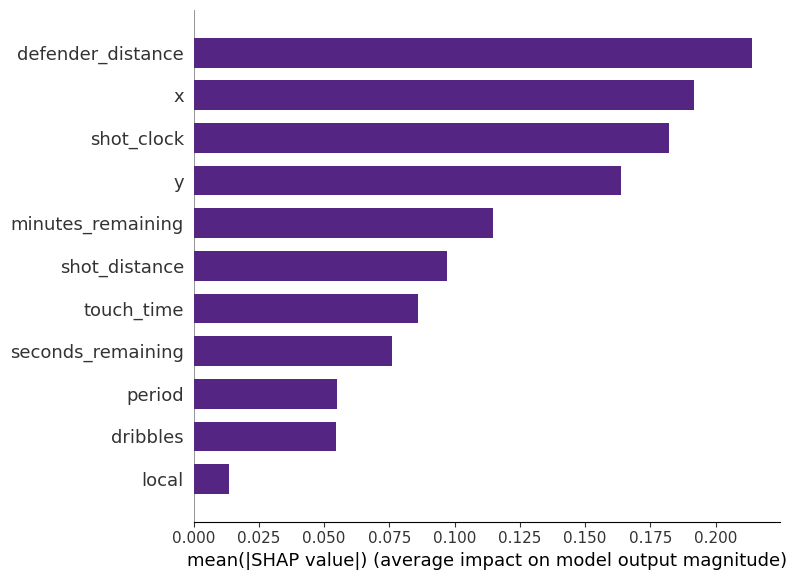

In [67]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Ensure the model_outputs directory exists
output_dir = "model_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load the dataset
data_path = 'mergeFinalC_with_local.csv'
data = pd.read_csv(data_path)

# Select relevant features for modeling
features = ['period', 'minutes_remaining','touch_time','local','dribbles', 'seconds_remaining', 'shot_distance', 'x', 'y', 'defender_distance', 'shot_clock']
target = 'shot_made_flag'

# Drop rows with missing values in relevant columns
data = data.dropna(subset=features + [target])

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True)
}

# Train and evaluate models
model_accuracies = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Save model accuracies to a CSV file
model_accuracies_df = pd.DataFrame(model_accuracies.items(), columns=['Model', 'Accuracy'])
model_accuracies_df.to_csv(os.path.join(output_dir, 'model_accuracies.csv'), index=False)

# Select the best model (highest accuracy)
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = models[best_model_name]

# Compute SHAP values
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)

# Plot overall feature importance with SHAP
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar", color='#552583')
plt.title('Overall Feature Importance with SHAP')
plt.savefig(os.path.join(output_dir, 'shap_feature_importance.png'))
plt.close()

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=features, color='#552583')
plt.title('SHAP Summary Plot')
plt.savefig(os.path.join(output_dir, 'shap_summary_plot.png'))
plt.close()

# Separate data into 2-pointers and 3-pointers
data_2pointers = data[data['shot_distance'] <= 23.75]
data_3pointers = data[data['shot_distance'] > 23.75]

# Function to train model and get SHAP values
def analyze_shap_values(data_subset):
    X = data_subset[features]
    y = data_subset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model.fit(X_train_scaled, y_train)
    explainer = shap.Explainer(best_model, X_train_scaled)
    shap_values = explainer(X_test_scaled, check_additivity=False)
    return shap_values, X_test

# Analyze SHAP values for 2-pointers
shap_values_2pointers, X_test_2pointers = analyze_shap_values(data_2pointers)
shap.summary_plot(shap_values_2pointers, X_test_2pointers, feature_names=features, color='#552583')
plt.title('SHAP Summary Plot for 2-pointers')
plt.savefig(os.path.join(output_dir, 'shap_summary_plot_2pointers.png'))
plt.close()

# Analyze SHAP values for 3-pointers
shap_values_3pointers, X_test_3pointers = analyze_shap_values(data_3pointers)
shap.summary_plot(shap_values_3pointers, X_test_3pointers, feature_names=features, color='#552583')
plt.title('SHAP Summary Plot for 3-pointers')
plt.savefig(os.path.join(output_dir, 'shap_summary_plot_3pointers.png'))
plt.close()

# Plot feature importance for 2-pointers with SHAP
shap.summary_plot(shap_values_2pointers, X_test_2pointers, feature_names=features, plot_type="bar", color='#552583')
plt.title('Feature Importance for 2-pointers with SHAP')
plt.savefig(os.path.join(output_dir, 'shap_feature_importance_2pointers.png'))
plt.close()

# Plot feature importance for 3-pointers with SHAP
shap.summary_plot(shap_values_3pointers, X_test_3pointers, feature_names=features, plot_type="bar", color='#552583')
plt.title('Feature Importance for 3-pointers with SHAP')
plt.savefig(os.path.join(output_dir, 'shap_feature_importance_3pointers.png'))
plt.close()


In [48]:
import pandas as pd

# Load the dataset
data_path = 'mergeFinalC_with_local.csv'
data = pd.read_csv(data_path)

# Load the recommendations file
recommendations_path = 'Player_Recommendations.csv'
recommendations = pd.read_csv(recommendations_path)

# Merge the recommendations into the shot data file
data = data.merge(recommendations, how='left', left_on='name', right_on='player')

# Save the resulting merged data to a new CSV file
merged_data_path = 'merged_shots_with_recommendations.csv'
data.to_csv(merged_data_path, index=False)

print(f"Merged data saved to {merged_data_path}")


Merged data saved to merged_shots_with_recommendations.csv


In [50]:
import os
from PIL import Image

# Define the input and output directories
input_dir = 'Shots_Charts'
output_dir = 'Shots_ChartsBig'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Open the image
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)

        # Double the size of the image
        new_size = (img.width * 2, img.height * 2)
        img_resized = img.resize(new_size, Image.LANCZOS)

        # Save the resized image to the output directory
        output_path = os.path.join(output_dir, filename)
        img_resized.save(output_path)

        print(f"Processed {filename}")

print("All images have been resized and saved to the output directory.")


Processed Carlos Boozer_shot_chart.png
Processed Dwight Buycks_shot_chart.png
Processed Ed Davis_shot_chart.png
Processed Jabari Brown_shot_chart.png
Processed Jeremy Lin_shot_chart.png
Processed Jordan Clarkson_shot_chart.png
Processed Jordan Hill_shot_chart.png
Processed Julius Randle_shot_chart.png
Processed Kobe Bryant_shot_chart.png
Processed Nick Young_shot_chart.png
Processed Robert Sacre_shot_chart.png
Processed Ronnie Price_shot_chart.png
Processed Ryan Kelly_shot_chart.png
Processed Tarik Black_shot_chart.png
Processed Vander Blue_shot_chart.png
Processed Wayne Ellington_shot_chart.png
Processed Wesley Johnson_shot_chart.png
Processed Xavier Henry_shot_chart.png
All images have been resized and saved to the output directory.


In [66]:
import os
from PIL import Image

# Define los directorios de entrada y salida
input_dir = 'Shots_ChartsBig'
output_dir = 'Shots_ChartsProcessed'

# Asegúrate de que el directorio de salida exista
os.makedirs(output_dir, exist_ok=True)

# Función para recortar márgenes
def crop_margins(image, horizontal_margin=0.1, vertical_margin=0.05):
    width, height = image.size
    left = int(width * horizontal_margin)
    right = width - left
    top = int(height * vertical_margin)
    bottom = height - top
    return image.crop((left, top, right, bottom))

# Procesar cada imagen en el directorio de entrada
for filename in os.listdir(input_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Abrir la imagen
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)

        # Recortar los márgenes
        img_cropped = crop_margins(img)

        # Aumentar el tamaño de la imagen 2 veces
        new_size = (img_cropped.width * 3, img_cropped.height * 3)
        img_resized = img_cropped.resize(new_size, Image.LANCZOS)

        # Guardar la imagen procesada en el directorio de salida
        output_path = os.path.join(output_dir, filename)
        img_resized.save(output_path)

        print(f"Procesada {filename}")

print("Todas las imágenes han sido recortadas y redimensionadas.")


Procesada Carlos Boozer_shot_chart.png
Procesada Dwight Buycks_shot_chart.png
Procesada Ed Davis_shot_chart.png
Procesada Jabari Brown_shot_chart.png
Procesada Jeremy Lin_shot_chart.png
Procesada Jordan Clarkson_shot_chart.png
Procesada Jordan Hill_shot_chart.png
Procesada Julius Randle_shot_chart.png
Procesada Kobe Bryant_shot_chart.png
Procesada Nick Young_shot_chart.png
Procesada Robert Sacre_shot_chart.png
Procesada Ronnie Price_shot_chart.png
Procesada Ryan Kelly_shot_chart.png
Procesada Tarik Black_shot_chart.png
Procesada Vander Blue_shot_chart.png
Procesada Wayne Ellington_shot_chart.png
Procesada Wesley Johnson_shot_chart.png
Procesada Xavier Henry_shot_chart.png
Todas las imágenes han sido recortadas y redimensionadas.
